In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

# Pandas for time series

Pandas is very useful for handling time series. 

First we'll need some data. I started at [Diskos](https://portal.diskos.cgg.com/whereoil-data/). It's a bit confusing as there are a lot of places to get data, but I've heard of FactPages so let's start there.

## FactPages... Use pandas to read CSV directly

Right-click and copy URL for CSV from this link:

http://factpages.npd.no/factpages/Default.aspx?culture=nb-no&nav1=field&nav2=TableView|Production|Saleable|Monthly

Then we can make a dataframe and look at some stats...

,water,other,oil
count,20075.000000,20075.000000,20075.000000
mean,0.157344,0.150009,0.217905
std,0.393492,0.381016,0.403998
min,-0.002980,-0.073300,-0.037570
25%,0.000000,0.001105,0.009120
50%,0.004340,0.026080,0.060230
75%,0.120955,0.111685,0.250220
max,3.651950,3.886370,3.453530


## Rename some columns

In [16]:
columns = {'prfYear': 'year',
           'prfMonth': 'month',
           'prfInformationCarrier': 'field',
           'prfPrdOilNetMillSm3': 'oil',
           'prfPrdOeNetMillSm3': 'OE',
           'prfPrdProducedWaterInFieldMillSm3': 'water',
          }

df = df.rename(columns=columns)

## Add a datetime

We'd like to give this dataframe a **datetime** index with `pandas` datetimes. To do this easily, we need:

- EITHER columns named like `'year'`, `'month'`, `'day'`
- OR a column with a datetime string like `2019-06-30`.

In this dataframe, we have the former, so let's work with that.

## Simplify the dataframe

Before we carry on, let's simplify the dataframe a bit, reducing it to a few columns: **field**, **water**, **other**, and **oil** (the order is a slightly cheaty way to get the colours I want on the charts, without having to fiddle with them).

## Time series with `pandas`

`pandas` knows all about time series. So we can easily make a time series plot:

## Forecasting with Facebook Prophet

Prophet implements [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), with seasonal modeling and automatic setting of lag, degree of differencing, etc. We'll run it completely hands-free.

We'll make a new dataframe, because it has to have slightly different columns.

In [31]:
dt = troll.loc['1997':].reset_index()
dt['y'] = dt['other']

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


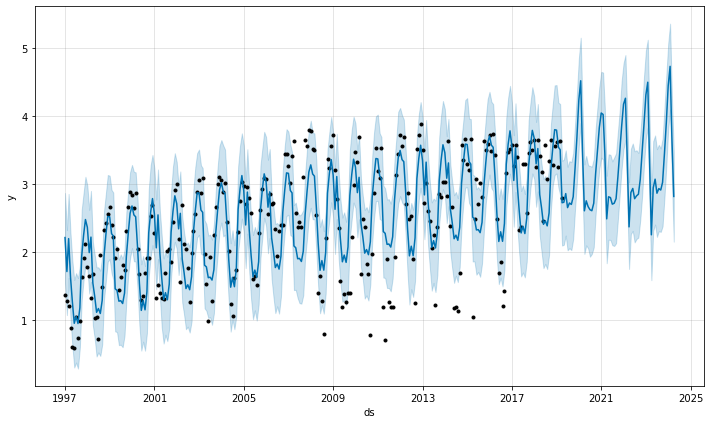

In [34]:
from fbprophet import Prophet

model = Prophet()

model.fit(dt)

future = model.make_future_dataframe(periods=60, freq='M')

forecast = model.predict(future)

fig = model.plot(forecast)

## Add operating companies

There's also a list of operators here >> http://factpages.npd.no/factpages/Default.aspx?culture=nb-no&nav1=field&nav2=TableView%7cProduction%7cSaleable%7cMonthly

This file is also in `/data`, but we can read directly from the web with `pandas`, as before:

In [35]:
url = "http://factpages.npd.no/ReportServer?/FactPages/TableView/field_operator_hst&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=134.41.39.109&CultureCode=nb-no"
dg = pd.read_csv(url)

In [36]:
dg.head()

,fldName,cmpLongName,fldOperatorFrom,fldOperatorTo,fldNpdidField,cmpNpdidCompany,fldOperatorDateUpdated,datesyncNPD
0,ALBUSKJELL,Phillips Petroleum Company Norway,25.04.1975,22.10.2002,43437,694,NaN,07.07.2019
1,ALBUSKJELL,ConocoPhillips Norge,23.10.2002,31.03.2003,43437,2144081,01.12.2016,07.07.2019
2,ALBUSKJELL,Phillips Petroleum Norsk AS,01.04.2003,05.05.2003,43437,705,01.12.2016,07.07.2019
3,ALBUSKJELL,ConocoPhillips Skandinavia AS,06.05.2003,NaN,43437,2410696,NaN,07.07.2019
4,ALVE,Statoil ASA (old),16.03.2007,30.09.2007,4444332,1622484,NaN,07.07.2019


In [37]:
dg['from'] = pd.to_datetime(dg.fldOperatorFrom)
dg['to'] = pd.to_datetime(dg.fldOperatorTo)
dg['to'] = dg['to'].fillna(pd.to_datetime('today'))

In [38]:
dg.head()

,fldName,cmpLongName,fldOperatorFrom,fldOperatorTo,fldNpdidField,cmpNpdidCompany,fldOperatorDateUpdated,datesyncNPD,from,to
0,ALBUSKJELL,Phillips Petroleum Company Norway,25.04.1975,22.10.2002,43437,694,NaN,07.07.2019,1975-04-25,2002-10-22 00:00:00.000000
1,ALBUSKJELL,ConocoPhillips Norge,23.10.2002,31.03.2003,43437,2144081,01.12.2016,07.07.2019,2002-10-23,2003-03-31 00:00:00.000000
2,ALBUSKJELL,Phillips Petroleum Norsk AS,01.04.2003,05.05.2003,43437,705,01.12.2016,07.07.2019,2003-01-04,2003-05-05 00:00:00.000000
3,ALBUSKJELL,ConocoPhillips Skandinavia AS,06.05.2003,NaN,43437,2410696,NaN,07.07.2019,2003-06-05,2019-07-07 18:34:38.720801
4,ALVE,Statoil ASA (old),16.03.2007,30.09.2007,4444332,1622484,NaN,07.07.2019,2007-03-16,2007-09-30 00:00:00.000000


Let's get the operator of each field, for each month, and put it in our production dataframe.

There is probably a more elegant way to do this with `join` or `merge` or something... but I can't figure it out.

In [39]:
import numpy as np

def process_row(row):
    """
    Process a row in df to get the operator at that time.
    
    Note that 'name' is a special attribute for the current index.
    """
    this_df = dg.loc[dg.fldName==row.field, :]
    record = this_df.loc[(dg['from'] < row.name) & (row.name <= dg['to']), "cmpLongName"]
    if any(record.values):
        return record.values[0]
    else:
        return np.nan

In [40]:
df['operator'] = df.apply(process_row, axis=1)

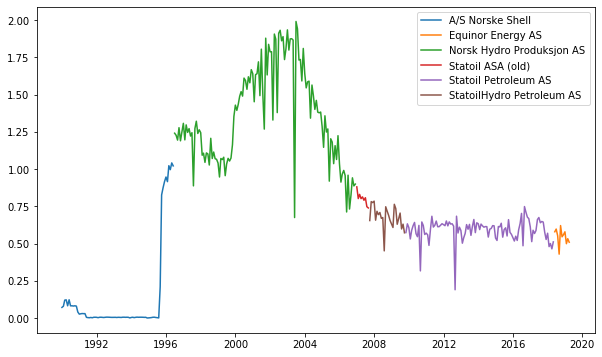

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for name, group in df[df.field=='TROLL'].groupby('operator'):
    plt.plot(group.oil, label=name)
plt.legend()

----

(c) Agile Scientific 2019, licensed CC-BY